# Features engineering

In [7]:
!pip install holidays

     -------------------------------------- 917.9/917.9 kB 1.6 MB/s eta 0:00:00


In [51]:
#Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

#### Obtención de variables temporales

Con el objtivo de analizar variables temporales como, día de la semana, si es fin de semana, si es un día de fiesta, la temporada del año que es, y el tiempo en el día que se está analizando, se realiza la implementación de estas funciones.

In [ ]:
#Loading Dataset preprocessed

dataPath = "../data/processed/pro_household_power_consumption.csv"

dataset = pd.read_csv(dataPath, index_col=0, parse_dates=True)
dataset.head(5)

Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  
Datetime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

In [38]:
def get_season(date):
    """
        Return: 0 -> 'Winter'
                1 -> 'Spring'
                2 -> 'Summer'
                3 -> 'Autumn'
    """
    Y = date.year
    if date < pd.Timestamp(f'{Y}-03-21'):
        return 0
    elif date < pd.Timestamp(f'{Y}-06-21'):
        return 1
    elif date < pd.Timestamp(f'{Y}-09-21'):
        return 2
    elif date < pd.Timestamp(f'{Y}-12-21'):
        return 3
    else:
        return 0

In [39]:
def time_of_day(hour):
    """
        Return: 0 -> 'Night'
                1 -> 'Morning'
                2 -> 'Afternoon'
                3 -> 'Evening'
    """
    if 0 <= hour < 6:
        return 0
    elif 6 <= hour < 12:
        return 1
    elif 12 <= hour < 18:
        return 2
    else:
        return 3


In [40]:
def ResamplingDF(df):
    dtemp_rhm = df.resample('H').mean()     # resample by hour with mean
    dtemp_rdm = df.resample('D').mean()     # resample by day with mean
    dtemp_rwm = df.resample('W').mean()     # resample by week with mean
    dtemp_rmm = df.resample('M').mean()     # resample by month with mean

    dtemp_rhm['day_of_week'] = dtemp_rhm.index.dayofweek                                          # Adding day of week resample by hour (0 = monday, 6 = sunday)
    dtemp_rhm['is_weekend'] = dtemp_rhm['day_of_week'].isin([5, 6]).astype(int)            # Adding column to indicate if the day is a weekend (1 = yes, 0 = no)
    fr_holidays = holidays.France()                                                        # Holidays
    dtemp_rhm['is_holiday'] = [date in fr_holidays for date in dtemp_rhm.index.date]  # Adding column to indicate if the day is a holiday (True = yes, False = no)
    dtemp_rhm['season'] = dtemp_rhm.index.map(get_season)                                  # Adding column to determine the season based on the date
    dtemp_rhm['time_of_day'] = dtemp_rhm.index.hour.map(time_of_day)                       # Adding Column to determine the time of day

    return dtemp_rhm, dtemp_rdm, dtemp_rwm, dtemp_rmm

In [41]:
dtemp_rhm, dtemp_rdm, dtemp_rwm, dtemp_rmm = ResamplingDF(dataset)

dtemp_rhm.head(10)

Global_active_power  Global_reactive_power     Voltage  \
Datetime                                                                      
2006-12-16 17:00:00             4.222889               0.229000  234.643889   
2006-12-16 18:00:00             3.632200               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   
2006-12-16 22:00:00             2.200133               0.056167  238.760000   
2006-12-16 23:00:00             2.061600               0.071433  240.619667   
2006-12-17 00:00:00             1.882467               0.102433  240.961833   
2006-12-17 01:00:00             3.349400               0.136933  240.448333   
2006-12-17 02:00:00             1.587267               0.078233  245.818667   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:00:00         18.100000             0.0        0.527778   
2006-12-16 18:00:00         15.600000             0.0        6.716667   
2006-12-16 19:00:00         14.503333             0.0        1.433333   
2006-12-16 20:00:00         13.916667             0.0        0.000000   
2006-12-16 21:00:00         13.046667             0.0        0.416667   
2006-12-16 22:00:00          9.523333             0.0        0.133333   
2006-12-16 23:00:00          8.896667             0.0        0.083333   
2006-12-17 00:00:00          8.126667             0.0        0.466667   
2006-12-17 01:00:00         14.246667             0.0       25.233333   
2006-12-17 02:00:00          6.870000             0.0        0.566667   

                     Sub_metering_3  day_of_week  is_weekend  is_holiday  \
Datetime                                                                   
2006-12-16 17:00:00       16.861111            5           1       False   
2006-12-16 18:00:00       16.866667            5           1       False   
2006-12-16 19:00:00       16.683333            5           1       False   
2006-12-16 20:00:00       16.783333            5           1       False   
2006-12-16 21:00:00       17.216667            5           1       False   
2006-12-16 22:00:00        4.433333            5           1       False   
2006-12-16 23:00:00        0.000000            5           1       False   
2006-12-17 00:00:00        0.000000            6           1       False   
2006-12-17 01:00:00        0.000000            6           1       False   
2006-12-17 02:00:00        0.000000            6           1       False   

                     season  time_of_day  
Datetime                                  
2006-12-16 17:00:00       3            2  
2006-12-16 18:00:00       3            3  
2006-12-16 19:00:00       3            3  
2006-12-16 20:00:00       3            3  
2006-12-16 21:00:00       3            3  
2006-12-16 22:00:00       3            3  
2006-12-16 23:00:00       3            3  
2006-12-17 00:00:00       3            0  
2006-12-17 01:00:00       3            0  
2006-12-17 02:00:00       3            0

In [42]:
def plot_pattern_by_filter(df, column_filter, filter_value, variable='Global_active_power'):
    """
    Filtra el DataFrame por un valor específico en una columna y genera un gráfico de línea para la variable seleccionada.
    
    Parámetros:
    - df: DataFrame con índice datetime y columnas como 'day_of_week', 'season', 'is_holiday', etc.
    - column_filter: str, nombre de la columna para filtrar (ej. 'day_of_week')
    - filter_value: valor para aplicar el filtro (ej. 0 para lunes)
    - variable: str, nombre de la variable a graficar (por defecto 'Global_active_power')
    """
    # Filtrado
    df_filtered = df[df[column_filter] == filter_value]
    
    # Agrupación por hora del día si existe la columna correspondiente
    if 'hour' in df_filtered.columns:
        grouped = df_filtered.groupby('hour')[variable].mean()
        x_label = 'Hour of Day'
    else:
        grouped = df_filtered[variable]
        x_label = column_filter
    
    # Gráfico
    plt.figure(figsize=(10, 5))
    #plt.plot(grouped.index, grouped.values, marker='o', linestyle='-', color='steelblue')
    plt.plot(grouped.index, grouped.values, color='steelblue')
    plt.title(f'{variable} Pattern - {column_filter} = {filter_value}')
    plt.xlabel(x_label)
    plt.ylabel(variable)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

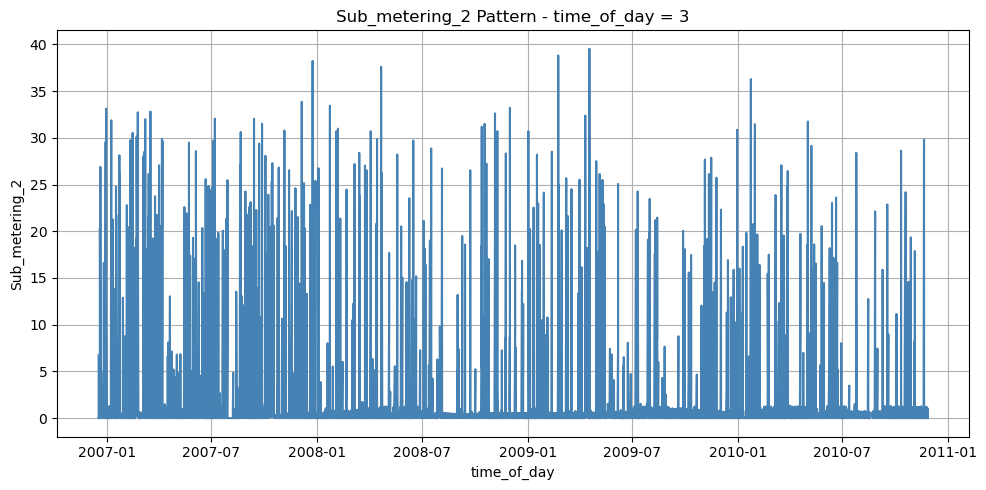

In [44]:
plot_pattern_by_filter(dtemp_rhm, column_filter ='time_of_day', filter_value = 3, variable= 'Sub_metering_2')

### Transformación de los datos para realizar feature engineering

In [66]:
def clean_and_log_transform(X):
    X = X.copy()
    # Reemplaza valores negativos con cero si lo consideras apropiado
    X[X < 0] = 0
    
    # Aplicamos log1p y manejamos valores infinitos
    X_log = np.log1p(X)
    X_log = np.where(np.isfinite(X_log), X_log, 0)  # reemplaza inf o nan con 0
    return X_log

def build_statistical_pipeline():
    # Transformación logarítmica segura (log1p = log(1+x))
    log_transform = FunctionTransformer(clean_and_log_transform, validate=False)

    # Normalización (Z-score)
    scaler = StandardScaler()

    # Construcción del pipeline
    pipeline = Pipeline([
        ('log_transform', log_transform),
        ('scaler', scaler)
    ])
    return pipeline

In [54]:
features = [
    'Global_active_power',
    'Global_reactive_power',
    'Voltage',
    'Global_intensity',
    'Sub_metering_1',
    'Sub_metering_2',
    'Sub_metering_3'
]

In [70]:
pipeline = build_statistical_pipeline()
X = dtemp_rhm[features].copy()
X_transformed = pipeline.fit_transform(X)

# Crear DataFrame transformado
df_rhm_transformed = pd.DataFrame(
    X_transformed,
    index=dtemp_rhm.index,
    columns=[f"{col}_scaled" for col in features]
)

# Normalización (Z-score)
scaler = StandardScaler()
df_rhm_scaled = scaler.fit_transform(dtemp_rhm)

In [68]:
df_rhm_transformed.head(10)

Global_active_power_scaled  Global_reactive_power_scaled  \
Datetime                                                                        
2006-12-16 17:00:00                    2.561101                      1.602495   
2006-12-16 18:00:00                    2.254498                     -0.633315   
2006-12-16 19:00:00                    2.123257                     -0.550202   
2006-12-16 20:00:00                    2.045649                     -0.712535   
2006-12-16 21:00:00                    1.915450                     -0.687338   
2006-12-16 22:00:00                    1.309700                     -1.019984   
2006-12-16 23:00:00                    1.196646                     -0.771652   
2006-12-17 00:00:00                    1.042624                     -0.278102   
2006-12-17 01:00:00                    2.093573                      0.255111   
2006-12-17 02:00:00                    0.766612                     -0.662177   

                     Voltage_scaled  Global_intensity_scaled  \
Datetime                                                       
2006-12-16 17:00:00        0.067991                 2.233582   
2006-12-16 18:00:00        0.067542                 2.016211   
2006-12-16 19:00:00        0.058010                 1.910307   
2006-12-16 20:00:00        0.063951                 1.850534   
2006-12-16 21:00:00        0.085627                 1.757419   
2006-12-16 22:00:00        0.096760                 1.309942   
2006-12-16 23:00:00        0.109597                 1.214808   
2006-12-17 00:00:00        0.111948                 1.089303   
2006-12-17 01:00:00        0.108418                 1.884439   
2006-12-17 02:00:00        0.144966                 0.859758   

                     Sub_metering_1_scaled  Sub_metering_2_scaled  \
Datetime                                                            
2006-12-16 17:00:00              -0.366222               0.003340   
2006-12-16 18:00:00              -0.366222               2.526417   
2006-12-16 19:00:00              -0.366222               0.728448   
2006-12-16 20:00:00              -0.366222              -0.656907   
2006-12-16 21:00:00              -0.366222              -0.114290   
2006-12-16 22:00:00              -0.366222              -0.461919   
2006-12-16 23:00:00              -0.366222              -0.532211   
2006-12-17 00:00:00              -0.366222              -0.060255   
2006-12-17 01:00:00              -0.366222               4.432703   
2006-12-17 02:00:00              -0.366222               0.042499   

                     Sub_metering_3_scaled  
Datetime                                    
2006-12-16 17:00:00               1.296467  
2006-12-16 18:00:00               1.296736  
2006-12-16 19:00:00               1.287797  
2006-12-16 20:00:00               1.292684  
2006-12-16 21:00:00               1.313551  
2006-12-16 22:00:00               0.265001  
2006-12-16 23:00:00              -1.201977  
2006-12-17 00:00:00              -1.201977  
2006-12-17 01:00:00              -1.201977  
2006-12-17 02:00:00              -1.201977

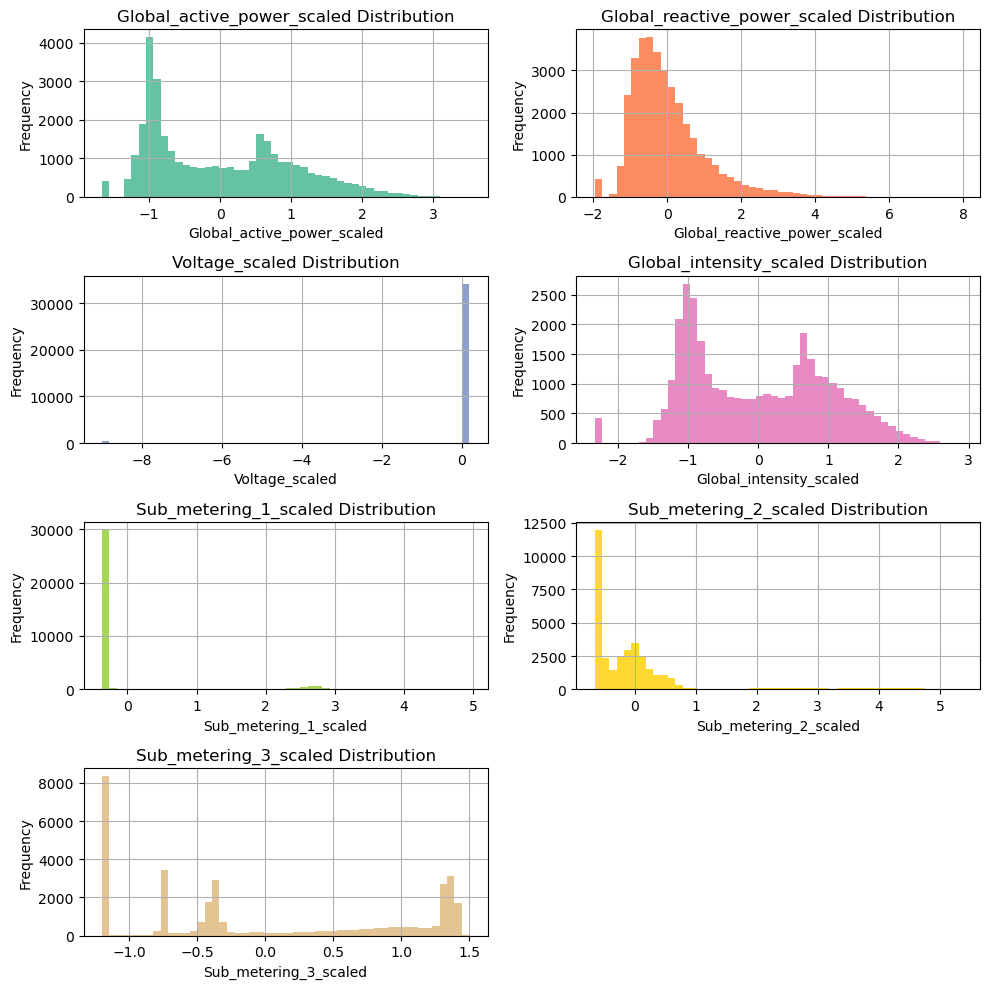

In [72]:
colors = sns.color_palette("Set2", len(df_rhm_transformed.columns))

plots_per_row = 2

num_rows = len(df_rhm_transformed.columns) // plots_per_row + (len(df_rhm_transformed.columns) % plots_per_row > 0)

fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(10, 10))

axes = axes.flatten()

for i, (col, color) in enumerate(zip(df_rhm_transformed.columns, colors)):
    df_rhm_transformed[col].hist(bins=50, ax=axes[i], color=color)
    axes[i].set_title(f"{col} Distribution")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()